In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
# FUNCTIONS USED TO CALCULATE ANGLES

def calculate_angle(point1,point2,point3):
    a = np.array(point1) #First
    b = np.array(point2) #Mid
    c = np.array(point3) #End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle 
    
def angle_of_singleline(point1, point2):
    """ Calculate angle of a single line """
    x_diff = point2[0] - point1[0]
    y_diff = point2[1] - point1[1]
    return math.degrees(math.atan2(y_diff, x_diff))

In [4]:
# RETRIEVES DETECTED LANDMARDS AND RESULTS USING MEDIA PIPE

def apply_detection_to_image(file):
    #import cv2
    pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)
    sample_img = cv2.imread(file)
    results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    landmarks = results.pose_landmarks.landmark
    return landmarks, results

In [5]:
# USES MEDIAPIPE LANDMARKS TO CALCULATE ANGLES

def get_pose_landmarks(landmarks):
    # GET COORDINATES OF JOINTS
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

    # CALCULATE SOME REQUIRED METRICS ANGLES
    # ANGLE FROM HORIZONTALS ARE POSITIVE CLOCKWISE, SO REQUIRES MINOR ADJUST TO BE CONSISTENT

    left_elbow_angle = np.round(calculate_angle(left_shoulder,left_elbow,left_wrist)).astype(int)
    #left_elbow_angle_hor = np.round(angle_of_singleline(left_elbow,left_wrist)).astype(int)
    left_elbow_angle_hor = np.round(-angle_of_singleline(left_elbow,left_wrist)).astype(int) #sign change to be consistent
    left_knee_angle = np.round(calculate_angle(left_hip, left_knee, left_ankle)).astype(int)
    left_knee_angle_ver = np.round(angle_of_singleline(left_knee,left_ankle)).astype(int)
    left_hip_angle = np.round(calculate_angle(left_shoulder,left_hip, left_knee)).astype(int)

    right_elbow_angle = np.round(calculate_angle(right_shoulder,right_elbow,right_wrist)).astype(int)
    right_elbow_angle_hor = np.round(angle_of_singleline(right_wrist,right_elbow)).astype(int)
    right_knee_angle = np.round(calculate_angle(right_hip, right_knee, right_ankle)).astype(int)
    right_knee_angle_ver = np.round(180-angle_of_singleline(right_knee,right_ankle)).astype(int)
    #right_knee_angle_ver = np.round(angle_of_singleline(right_knee, right_ankle)).astype(int) # gives angle from hotirontal "clockwise"
    right_hip_angle = np.round(calculate_angle(right_shoulder,right_hip, right_knee)).astype(int)

    return left_elbow_angle, left_elbow_angle_hor, left_knee_angle, left_knee_angle_ver, left_hip_angle, right_elbow_angle, right_elbow_angle_hor, right_knee_angle, right_knee_angle_ver, right_hip_angle
    

In [6]:
# PLOT OF IMAGE WITH SUPERIMPOSED LANDMARSK FOR QUALITY CHECK

def plot_figure(file, results):
    #pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

    sample_img = cv2.imread(file)

    img_copy = sample_img.copy()

    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])
 
    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

# RUN THIS CELL TO CREATE ML MODEL FROM NEW SET OF IMAGES

In [7]:

# DATA TRAINING READING ROUTINE (works for jpg, png)
# EXPECTS following structure:
# in folder /google_images/ there is one folder per yoga pose. For example, feft_warrior2, right_warrior2
# google_images/left_warrior2
# google_images/right_warrior2
# in each folder, there are images showing the pose
# this script reads each image, gets the landmarks with mediapie, calculate angles

image_dir = 'google_images/'
pose_examples = os.listdir(image_dir)
pose_images = {}
pose_all_data = []
pose_label = []
pose_data = []
for poses in pose_examples:
    file_list =  os.listdir(image_dir + poses)
    pose_images[poses]=file_list

pose_number = 0
for key in pose_images:
    for file in pose_images[key]:
        file_path = image_dir + key + '/' + file
        #print(file_path)
        landmarks0, results0 = apply_detection_to_image(file_path)
        markers0 = get_pose_landmarks(landmarks0)
        pose_all_data.append([key, pose_number, file_path,  markers0])
        pose_data.append(markers0)
        pose_label.append(pose_number)
        #plot_figure(file_path, results0) # uncomment to Quality test detection on image
    pose_number = pose_number + 1
pose_data_np = np.array(pose_data)
pose_label_np = np.array(pose_label)



In [8]:
image_dir = 'google_images/'
pose_examples = os.listdir(image_dir)
#left_elbow_angle, left_elbow_angle_hor, left_knee_angle, left_knee_angle_ver, left_hip_angle, right_elbow_angle, right_elbow_angle_hor, right_knee_angle, right_knee_angle_ver, right_hip_angle
features_str = ["left_elbow_angle", "left_elbow_angle_hor", "left_knee_angle", "left_knee_angle_ver", "left_hip_angle", "right_elbow_angle", "right_elbow_angle_hor", "right_knee_angle", "right_knee_angle_ver", "right_hip_angle"]
pose_names_str = pose_examples


In [9]:
# SAVE LANDMARK DATA
import pickle
filename1 = '.\ml_models\pose_data_np.save'
filename2 = '.\ml_models\pose_label_np.save'
pickle.dump(pose_data_np, open(filename1, 'wb'))
pickle.dump(pose_label_np, open(filename2,'wb'))

# RUN TO LOAD SAVED LANDMARKS

In [10]:


# LOAD LANDMARK DATA
import pickle
filename1 = '.\ml_models\pose_data_np.save'
filename2 = '.\ml_models\pose_label_np.save'

pose_data_np = pickle.load(open(filename1, 'rb'))
pose_label_np = pickle.load(open(filename2, 'rb'))


# CLASIFIER TESTS WITH SCIKIT-LEARN

In [22]:
#!pip install -U scikit-learn
#!pip install seaborn
#!pip uninstall seaborn

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import validation_curve
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, precision_recall_curve, roc_curve, auc, mean_squared_error,
                             r2_score, roc_auc_score)
import pickle

In [12]:
# ML MODEL TRAINING

X_train, X_test, y_train, y_test = train_test_split(pose_data_np, pose_label_np, random_state = 2)


# DECISION TREE

clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

# RANDOM FOREST

clf_rf = RandomForestClassifier().fit(X_train, y_train)

print('Accuracy of Random Forest classifier on training set: {:.2f}'
     .format(clf_rf.score(X_train, y_train)))
print('Accuracy of Random Forest classifier on test set: {:.2f}'
     .format(clf_rf.score(X_test, y_test)))

# SVC

clf_svc = SVC(kernel="rbf").fit(X_train, y_train)
print('Accuracy of RBF-kernel SVC on training set: {:.2f}'
     .format(clf_svc.score(X_train, y_train)))
print('Accuracy of RBF-kernel SVC on test set: {:.2f}'
     .format(clf_svc.score(X_test, y_test)))



Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.95
Accuracy of Random Forest classifier on training set: 1.00
Accuracy of Random Forest classifier on test set: 0.95
Accuracy of RBF-kernel SVC on training set: 0.99
Accuracy of RBF-kernel SVC on test set: 0.94


In [13]:
#PARAMETER SELECTION FOR SVC

grid_values = {'gamma': [0.001, 0.01, 0.05, 0.1, 1, 10, 100],'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}
#grid_values = {'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100]}

# default metric to optimize over grid parameters: accuracy
grid_clf_acc = GridSearchCV(clf_svc, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)
y_decision_fn_scores_acc = grid_clf_acc.decision_function(X_test) 

print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
print('Grid best score (accuracy): ', grid_clf_acc.best_score_)

clf_svc = SVC(kernel='rbf',C=10,gamma=0.001,probability=True).fit(X_train, y_train)

print('Accuracy of RBF-kernel SVC on training set: {:.2f}'
     .format(clf_svc.score(X_train, y_train)))
print('Accuracy of RBF-kernel SVC on test set: {:.2f}'
     .format(clf_svc.score(X_test, y_test)))


Grid best parameter (max. accuracy):  {'C': 10, 'gamma': 0.001}
Grid best score (accuracy):  0.959013605442177
Accuracy of RBF-kernel SVC on training set: 1.00
Accuracy of RBF-kernel SVC on test set: 0.93


# CONFUSION MATRIX

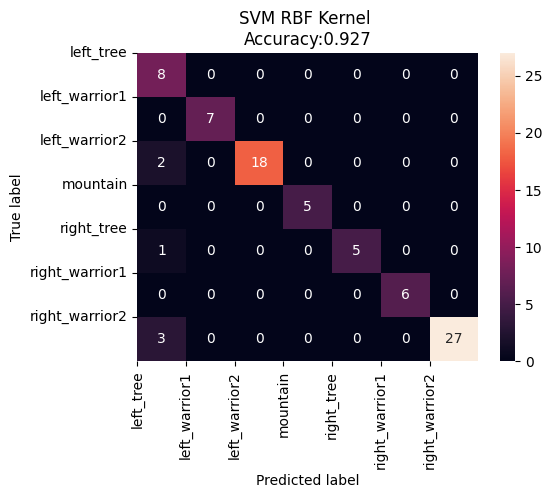

In [14]:
# CONFUSION MATRIX (NOT WORKING)
import seaborn as sns
svm_predicted_mc = clf_svc.predict(X_test)

confusion_mc = confusion_matrix(y_test, svm_predicted_mc)

df_cm = pd.DataFrame(confusion_mc, index = [i for i in range(0,7)],columns = [i for i in range(0,7)])

plt.figure(figsize = (5.5,4))
sns.heatmap(df_cm, annot=True)
plt.title('SVM RBF Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, svm_predicted_mc)))
plt.ylabel('True label')
plt.xlabel('Predicted label');
plt.xticks([0,1,2,3,4,5,6], labels=pose_names_str,rotation=90)
plt.yticks([0,1,2,3,4,5,6], labels=pose_names_str,rotation=0)
plt.show()

In [15]:

# save the model to disk
filename1 = '.\ml_models\yoga_poses_decisiontree.model'
filename2 = '.\ml_models\yoga_poses_decisiontree.labels'
pickle.dump(clf, open(filename1, 'wb'))
pickle.dump(pose_names_str, open(filename2,'wb'))
 

In [16]:
# save the model to disk
filename1 = '.\ml_models\yoga_poses_randomforest.model'
filename2 = '.\ml_models\yoga_poses_randomforest.labels'
pickle.dump(clf_rf, open(filename1, 'wb'))
pickle.dump(pose_names_str, open(filename2,'wb'))

In [17]:
# save the model to disk
filename1 = '.\ml_models\yoga_poses_svc.model'
filename2 = '.\ml_models\yoga_poses_svc.labels'
pickle.dump(clf_svc, open(filename1, 'wb'))
pickle.dump(pose_names_str, open(filename2,'wb'))

## PLOT DECISION TREE

In [ ]:
# UNCOMMENT THESE LINES TO PLOT A FIGURE

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=150)
#plot_tree(clf, feature_names=features_str, class_names=pose_names_str, filled=True, fontsize=8)

#### TEST THE CODE WITH NEW IMAGES

In [36]:
########################################################################
# TEST ML DETECTION MODE
########################################################################

# load saved model
#file1 = ".\ml_models\yoga_poses_decisiontree.model"
#file2 = ".\ml_models\yoga_poses_decisiontree.labels"

#file1 = ".\ml_models\yoga_poses_randomforest.model"
#file2 = ".\ml_models\yoga_poses_randomforest.labels"

file1 = ".\ml_models\yoga_poses_svc.model"
file2 = ".\ml_models\yoga_poses_svc.labels"

loaded_model = pickle.load(open(file1, 'rb'))
loaded_labels = pickle.load(open(file2, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)


file_path = "unseen_images/left_tree.jpg"
landmarks0, results0 = apply_detection_to_image(file_path)
markers0 = np.array(get_pose_landmarks(landmarks0)).reshape(1, -1)
markers0

# GET ML PREDICTION
predict_label = (loaded_model.predict(np.array(markers0).reshape(1, -1)))
pose_ml_detected = loaded_labels[predict_label[0]].upper()
print("Predicted label: ", predict_label[0])
print("Label corresponds to pose: ", pose_ml_detected)

print(loaded_labels)
probabilities = loaded_model.predict_proba(np.array(markers0).reshape(1, -1))
print("Probability of Detection: ", probabilities.max())


Predicted label:  0
Label corresponds to pose:  LEFT_TREE
['left_tree', 'left_warrior1', 'left_warrior2', 'mountain', 'right_tree', 'right_warrior1', 'right_warrior2']
Probability of Detection:  0.9411427220753046


In [ ]:

file_path = "unseen_images/left_tree.jpg"
landmarks0, results0 = apply_detection_to_image(file_path)
markers0 = np.array(get_pose_landmarks(landmarks0)).reshape(1, -1)
markers0

# GET PREDICTION
predict_label = (clf.predict(markers0))
print("Predicted label: ", predict_label[0])
print("Label corresponds to pose: ", pose_names_str[predict_label[0]])

In [ ]:
pose_names_str
